### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial u}{\partial t} - \kappa \nabla  u =Q \  \text{en} \  M=\Omega \times (0,T) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega = {x \in \mathbb{R}^2 : x_i \in (-0.5,0.5), i=1,2 }$$
$$ w(x_1,X_2) = [-4x_2,4x_1] $$
Y
$$T= \frac{\pi}{2}$$

tenemos que la solución analitica del problema esta dada por la función: 

$$
u(x,t)=\frac{1.0}{1.0+0.1t}exp(-\frac{(\bar{x_1}+0.25)^2+ \bar{x_2}^2}{0.004})
$$

donde: 
$$
\bar{x_1}=x_1cos(4t)+x_2sin(4t) 
$$
$$
\bar{x_2}=-x_1 sin(4t)+x_2cos(4t) 
$$
Primero creamos una malla:

$$
\int_{\Omega} \frac{\partial(u)}{\partial(t)} *v +0.0001{\nabla(u) \cdot \nabla(v)}+\nabla \cdot (w*u)vdx = 0
$$

In [1]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy
import time
import cupy
import cupyx
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import cupyx.scipy.sparse.linalg as linalge
from mshr import *
start = time.time()
flag ="R"
parameters['linear_algebra_backend'] = 'Eigen'
def tran2SparseMatrix(A):
    row, col, val = as_backend_type(A).data()
    return sps.csr_matrix((val, col, row))
mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 200# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo

# Creación de la malla y definición del espacio de funciones
nx = ny = 50# Número de divisiones en x e y
#R=Rectangle(Point(-0.5,-0.5),Point(0.5,0.5))
#mesh=generate_mesh(R,64)
mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),nx,ny)  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',2)
# definición de fronteras
class Dirichlet_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], start) and on_boundary


class Neumann_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], x_end) and on_boundary
class source(SubDomain):
    def inside(self, x, on_boundary):
        return ((x[1]>= 0.1) or (x[1]<=0.1)) and ((x[0]>= 0.1) or (x[0]<=0.1))

sub_domains=MeshFunction("size_t",mesh,mesh.topology().dim())
boundarys = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundarys.set_all(0)


Dirichlet_boundary().mark(boundarys, 0)  # mark left boundary with a 0
Neumann_boundary().mark(boundarys, 1)  # mark right boundary with a 1

# Definición de la condición de frontera
u_o = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
                 degree=2, a=5)

# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V

# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)
q_=Constant((0,-1000))

bc =DirichletBC(V,Constant(0.0),botton)
K_fem =0.0001*dot(grad(u), grad(v))*dx +div(w*u)*v*dx   # Formulación débil
C_fem=u*v*dx
q=dot(q,n)*ds(0)
# algoritmo de arnoldi 
def arnoldi_iteration_3(A, b, n):
    m = A.shape[0]

    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))

    q = b / np.linalg.norm(b)
    Q[:, 0] = q

    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q[:,0:n], h[0:n, 0:n]
    return Q[:,0:n], h[0:n, 0:n]

# proceso 
vtkfile_u = XDMFFile("results/u_exp.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t= 0
u_=Function(V)


K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
#bc.apply(K)
K_=scipy.sparse.csr_matrix(K.array()) 
C=assemble(C_fem)
N_degree=C.array().shape[0]
#C_c = tran2SparseMatrix(C)
#C_c = cupyx.scipy.sparse.csr_matrix(C_c)
#bc.apply(C)


#I_np=np.identity(N_degree)
#I_cupy=cupyx.scipy.sparse.identity(N_degree)
# A1 = assemble(L)
# [bc.apply(A1) for bc in bcs]


# b1 = assemble(R)
# [bc.apply(b1) for bc in bcs]
# b1= b1[:]
# b1 = cupy.array(b1)
# X_w.vector()[:] = cupy.asnumpy(linalge.spsolve(A1, b1))
    
C=scipy.sparse.csc_matrix(C.array().astype(np.float32))
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))

# 


start=time.time()
C_1=scipy.sparse.linalg.spsolve(C,I_n)
#C_1=np.linalg.solve(C.array(),I_np)
#C_1 = cupyx.scipy.sparse.linalg.spsolve(C_c, I_cupy)
end = time.time()
A=-C_1.dot(K_)
print(f"time inv ={end-start}")


u_n = interpolate(u_analytical, V)
u_i=u_n.vector().get_local()
m=15
v_hat=np.zeros(m)
v_hat[0]=1

for n in range(num_steps):
    t += dt
    
    
    print(f'step:{n} of {num_steps} time= {t}')
    
    Beta=np.linalg.norm(u_i)
    V_m,H_m = arnoldi_iteration_3(A,u_i,m)
    u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),v_hat.T)
    #u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
    u_.vector()[:]=u_i
    
    print(Beta)
    u_.rename("u_a", "u_a");vtkfile_u.write(u_, t)


NameError: name 'x_end' is not defined

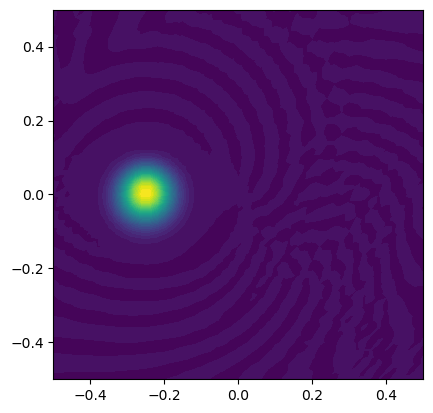

In [11]:
plot(u_)


In [2]:
vtkfile_u = XDMFFile("results/u_analitical.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t=0
for n in range(num_steps):
    t += dt
    u_analytical.t=t
    u_ana = project(u_analytical,V)
    u_ana.rename("u_a", "u_a");vtkfile_u.write(u_ana, t)
    Beta=np.linalg.norm(u_ana.vector().get_local())
    print(Beta)

10.085024586935628
10.081069642749458
10.07711934783074
10.073173693077466
10.069232669412555
10.065296267783763
10.061364479163602
10.057437294549255
10.053514704962469
10.049596701449492
10.045683275080988
10.041774416951924
10.037870118181518
10.033970369913133
10.0300751633142
10.026184489576133
10.022298339914247
10.018416705567672
10.014539577799269
10.010666947895558
10.006798807166616
10.002935146946013
9.999075958590723
9.99522123348104
9.991370963020511
9.98752513863583
9.98368375177679
9.979846793916172
9.976014256549687
9.972186131195894
9.9683624093961
9.964543082714322
9.96072814273716
9.956917581073764
9.953111389355735
9.949309559237035
9.945512082393936
9.941718950524933
9.937930155350662
9.934145688613834
9.930365542079148
9.926589707533228
9.922818176784538
9.919050941663317
9.915287994021492
9.911529325732621
9.9077749286918
9.904024794815603
9.900278916042009
9.89653728433032
9.892799891661094
9.889066730036074
9.885337791478115
9.881613068031115
9.877892551759931


In [20]:
u_n = interpolate(u_analytical, V)
u_i=u_n.vector().get_local()
K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
K_=K.array()
C=assemble(C_fem)
C_1=np.linalg.inv(C.array())
A=C_1*K_

In [11]:
V_m.shape

(41, 8)

In [12]:
H_m.shape

(8, 8)

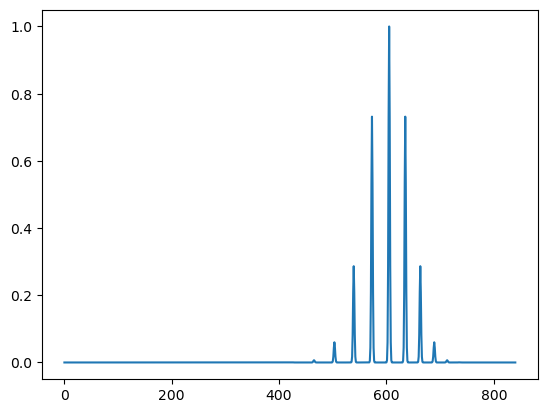

In [13]:
plt.plot(u_i)

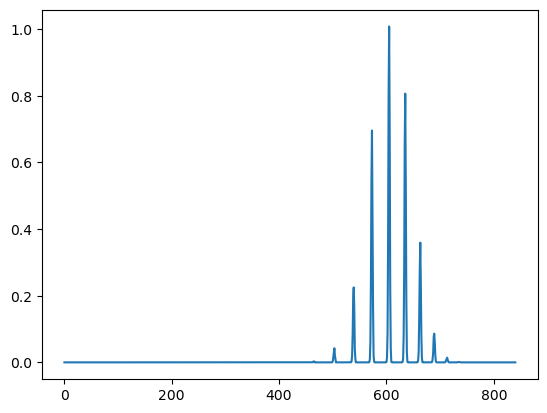

In [51]:
v_hat=np.array([1,0,0,0,0,0,0])
Beta=np.linalg.norm(u_i)
V_m,H_m = arnoldi_iteration_3(A,u_i,7)
u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),v_hat.T)
plt.plot(u_i)

In [54]:

Beta=np.linalg.norm(u_i)
V_m,H_m = arnoldi_iteration_3(A,u_i,8)
np.dot(np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),V_m.T),u_i)

NameError: name 'arnoldi_iteration' is not defined

In [16]:
u.vector()[:]=np.dot(scipy.linalg.expm(0.0001*A),u_i)

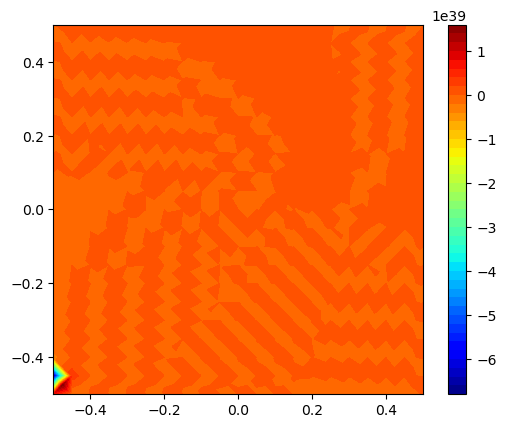

In [17]:

p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

In [45]:
u[1,:].shape

(51521,)

In [4]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy
import time
import cupy
import cupyx
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import cupyx.scipy.sparse.linalg as linalge
from mshr import *
start = time.time()
flag ="R"
parameters['linear_algebra_backend'] = 'Eigen'
def tran2SparseMatrix(A):
    row, col, val = as_backend_type(A).data()
    return sps.csr_matrix((val, col, row))
mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 2000# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo

# Creación de la malla y definición del espacio de funciones
nx = ny = 100# Número de divisiones en x e y
#R=Rectangle(Point(-0.5,-0.5),Point(0.5,0.5))
#mesh=generate_mesh(R,64)
mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),nx,ny)  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',2)
# definicion de fronteras
class topBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.5) and on_boundary


class bottonBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], -0.5) and on_boundary


sub_domain = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
sub_domain.set_all(0)

top = topBoundary()
botton = bottonBoundary()

top.mark(sub_domain, 0)  # mark left boundary with a 0
botton.mark(sub_domain, 1)  # mark right boundary with a 1
w =Expression(('-4*x[1]','4*x[0]'),degree=2)
w = interpolate(w,V_vec)
# Definición de la condición de frontera
u_o = Expression('(x[1]+0.5)*10',
                 degree=2, a=5)

# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V

# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)
q_=Constant((0,-1000))

bc =DirichletBC(V,Constant(0.0),botton)

# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_o, V) 
u_nnn = interpolate(u_o, V) 


# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
pconst= [11/6,-3,3/2,-1/3] #bdf 3
#pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0
u_=Function(V)
vtkfile_ubdf = XDMFFile("results_no_homogeneo/u_BDF.xdmf")
vtkfile_ubdf.parameters["flush_output"] = True
vtkfile_ubdf.parameters["rewrite_function_mesh"] = False
F = du_t*v*dx + dt*0.0001*dot(grad(u), grad(v))*dx +dt*(div(w*u))*v*dx -v*1000*ds(0) # Formulación débil
a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
for n in range(num_steps):

    # Actualizar el tiempo actual
    t += dt
    # Resolver la solución
    solve(a == L, u_,bc)
    # Graficar la solución
    print(f'step:{n} of {num_steps}')
    Beta=np.linalg.norm(u_.vector().get_local())
    print(Beta)
    # Calcular el error
#     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
#     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
#     print('t = %.2f: error = %.3g' % (t, error))

    # Actualizar la solución anterior
    u_nnn.assign(u_nn)
    u_nn.assign(u_n)
    u_n.assign(u_)
    if n%10==0:
        u_n.rename("u_a", "u_a");vtkfile_ubdf.write(u_n, t)
    



Solving linear variational problem.
step:0 of 2000
584.5793413455143
Solving linear variational problem.
step:1 of 2000
584.5788698629032
Solving linear variational problem.
step:2 of 2000
584.5785682099645
Solving linear variational problem.
step:3 of 2000
584.5783085140582
Solving linear variational problem.
step:4 of 2000
584.5779618695883
Solving linear variational problem.step:5 of 2000

584.5775042660744
Solving linear variational problem.
step:6 of 2000
584.5769608362809
Solving linear variational problem.
step:7 of 2000
584.5763540460084
Solving linear variational problem.
step:8 of 2000
584.5756903591025
Solving linear variational problem.
step:9 of 2000
584.5749658867961
Solving linear variational problem.step:10 of 2000

584.5741737124129
Solving linear variational problem.step:11 of 2000

584.5733075105297
Solving linear variational problem.
step:12 of 2000
584.5723622630936
Solving linear variational problem.
step:13 of 2000
584.5713338918165
Solving linear variational pro

Solving linear variational problem.
step:118 of 2000
583.9538686466971
Solving linear variational problem.
step:119 of 2000
583.9464857455507
Solving linear variational problem.
step:120 of 2000
583.939180519481
Solving linear variational problem.
step:121 of 2000
583.9319565559576
Solving linear variational problem.
step:122 of 2000
583.924817487568
Solving linear variational problem.
step:123 of 2000
583.917767009375
step:124 of 2000
Solving linear variational problem.
583.9108088851543
Solving linear variational problem.
step:125 of 2000
583.9039469394202
Solving linear variational problem.
step:126 of 2000
583.8971850353523
Solving linear variational problem.
step:127 of 2000
583.8905270422754
Solving linear variational problem.
step:128 of 2000
583.8839767992296
Solving linear variational problem.
step:129 of 2000
583.8775380825945
Solving linear variational problem.
step:130 of 2000
583.8712145851579
Solving linear variational problem.
step:131 of 2000
583.8650099115295
step:132 

Solving linear variational problem.
step:235 of 2000
584.4926088743883
Solving linear variational problem.
step:236 of 2000
584.5159094183185
Solving linear variational problem.
step:237 of 2000
584.5396066525008
Solving linear variational problem.
step:238 of 2000
584.5637000564602
Solving linear variational problem.
step:239 of 2000
584.5881897330925
Solving linear variational problem.
step:240 of 2000
584.6130766812527
Solving linear variational problem.
step:241 of 2000
584.6383628790381
Solving linear variational problem.
step:242 of 2000
584.6640511448314
Solving linear variational problem.
step:243 of 2000
584.6901447912131
Solving linear variational problem.
step:244 of 2000
584.7166471349404
Solving linear variational problem.
step:245 of 2000
584.7435609635845
Solving linear variational problem.step:246 of 2000

584.7708880768129
step:247 of 2000
Solving linear variational problem.
584.7986290121449
Solving linear variational problem.
step:248 of 2000
584.826783031174
Solving

step:352 of 2000
Solving linear variational problem.
589.974215191151
Solving linear variational problem.step:353 of 2000

590.0430310788585
Solving linear variational problem.
step:354 of 2000
590.1121513996487
Solving linear variational problem.
step:355 of 2000
590.1816152482893
Solving linear variational problem.
step:356 of 2000
590.2514552307954
Solving linear variational problem.
step:357 of 2000
590.321690650028
Solving linear variational problem.
step:358 of 2000
590.3923231552828
Solving linear variational problem.
step:359 of 2000
590.4633356971841
Solving linear variational problem.
step:360 of 2000
590.5346950204571
Solving linear variational problem.step:361 of 2000

590.6063572761138
Solving linear variational problem.
step:362 of 2000
590.678275743736
Solving linear variational problem.
step:363 of 2000
590.7504092253978
Solving linear variational problem.
step:364 of 2000
590.8227294978271
Solving linear variational problem.
step:365 of 2000
590.8952263492666
Solving l

Solving linear variational problem.
step:469 of 2000
599.4522514027602
Solving linear variational problem.
step:470 of 2000
599.5391510221162
Solving linear variational problem.
step:471 of 2000
599.6260403682902
Solving linear variational problem.
step:472 of 2000
599.7129516068242
Solving linear variational problem.
step:473 of 2000
599.7999119833851
Solving linear variational problem.
step:474 of 2000
599.8869379085536
Solving linear variational problem.
step:475 of 2000
599.9740310225073
Solving linear variational problem.step:476 of 2000

600.0611771236524
Solving linear variational problem.
step:477 of 2000
600.1483482675587
Solving linear variational problem.
step:478 of 2000
600.2355076580205
Solving linear variational problem.
step:479 of 2000
600.3226163385416
Solving linear variational problem.
step:480 of 2000
600.4096403090977
Solving linear variational problem.step:481 of 2000
600.4965566263284

Solving linear variational problem.
step:482 of 2000
600.5833572897108
Solvin

Solving linear variational problem.
step:586 of 2000
608.8905233993961
Solving linear variational problem.
step:587 of 2000
608.9582146410853
step:588 of 2000
609.0251807947759
Solving linear variational problem.
Solving linear variational problem.
step:589 of 2000
609.0914519895952
Solving linear variational problem.step:590 of 2000

609.1571355923683
Solving linear variational problem.
step:591 of 2000
609.2223978110799
Solving linear variational problem.step:592 of 2000

609.2874318122944
Solving linear variational problem.step:593 of 2000

609.3524178950931
Solving linear variational problem.
step:594 of 2000
609.4174835031818
Solving linear variational problem.
step:595 of 2000
609.4826718015819
Solving linear variational problem.
step:596 of 2000
609.5479265521514
Solving linear variational problem.step:597 of 2000

609.6130978897158
Solving linear variational problem.step:598 of 2000

609.6779689055517
step:599 of 2000Solving linear variational problem.

609.7422979829818
Solvin

613.7956482428331
Solving linear variational problem.
step:703 of 2000
613.7978906088692
Solving linear variational problem.
step:704 of 2000
613.8013021747744
Solving linear variational problem.
step:705 of 2000
613.8072004197242
step:706 of 2000
Solving linear variational problem.
613.8162866230077
Solving linear variational problem.
step:707 of 2000
613.8285544093955
Solving linear variational problem.
step:708 of 2000
613.843310818478
Solving linear variational problem.
step:709 of 2000
613.8592809960651
Solving linear variational problem.
step:710 of 2000
613.8747914767129
Solving linear variational problem.
step:711 of 2000
613.8880433771317
Solving linear variational problem.
step:712 of 2000
613.8974658414758
Solving linear variational problem.
step:713 of 2000
613.902085528701
Solving linear variational problem.step:714 of 2000

613.9017986101802
Solving linear variational problem.
step:715 of 2000
613.8974333961131
Solving linear variational problem.step:716 of 2000

613.8905

step:818 of 2000
610.6891628038411
Solving linear variational problem.
step:819 of 2000
610.6215665991194
Solving linear variational problem.
step:820 of 2000
610.5521336426226
Solving linear variational problem.
step:821 of 2000
610.4816778606502
Solving linear variational problem.
step:822 of 2000
610.4111941084556
Solving linear variational problem.
step:823 of 2000
610.3416238228561
Solving linear variational problem.
step:824 of 2000
610.2736411785047
Solving linear variational problem.step:825 of 2000

610.2075074123383
Solving linear variational problem.
step:826 of 2000
610.1430137347007
Solving linear variational problem.step:827 of 2000

610.0795116682518
Solving linear variational problem.step:828 of 2000
610.0160172197321
step:829 of 2000

Solving linear variational problem.
609.9513704170494
Solving linear variational problem.
step:830 of 2000
609.8844312354777
Solving linear variational problem.
step:831 of 2000
609.8142923423198
Solving linear variational problem.
step:8

Solving linear variational problem.
step:935 of 2000
600.954979527613
Solving linear variational problem.
step:936 of 2000
600.8967883294501
Solving linear variational problem.step:937 of 2000

600.8241173462076
Solving linear variational problem.step:938 of 2000

600.7372638750343
Solving linear variational problem.
step:939 of 2000
600.6384001269942
Solving linear variational problem.
step:940 of 2000
600.5310308492526
Solving linear variational problem.
step:941 of 2000
600.4205240985415
Solving linear variational problem.step:942 of 2000

600.3147058547416
Solving linear variational problem.
step:943 of 2000
600.223021176725
Solving linear variational problem.step:944 of 2000

600.1537248738521
Solving linear variational problem.
step:945 of 2000
600.1102700328793
Solving linear variational problem.
step:946 of 2000
600.0890935064955
Solving linear variational problem.
step:947 of 2000
600.0803934524462
Solving linear variational problem.
step:948 of 2000
600.0716057176124
Solving 

step:1050 of 2000
613.1303056833334
Solving linear variational problem.step:1051 of 2000

613.197682664995
Solving linear variational problem.
step:1052 of 2000
613.4493625197417
Solving linear variational problem.
step:1053 of 2000
613.9659922126342
Solving linear variational problem.
step:1054 of 2000
614.6678970899101
Solving linear variational problem.
step:1055 of 2000
615.3911703741177
Solving linear variational problem.step:1056 of 2000
616.0236078909387

Solving linear variational problem.
step:1057 of 2000
616.5923217021231
Solving linear variational problem.
step:1058 of 2000
617.231439265043
Solving linear variational problem.
step:1059 of 2000
618.053217579607
Solving linear variational problem.
step:1060 of 2000
619.0265254871491
Solving linear variational problem.step:1061 of 2000

619.967120096517
Solving linear variational problem.
step:1062 of 2000
620.658435043914
Solving linear variational problem.step:1063 of 2000

621.0158147095525
Solving linear variational proble

step:1166 of 2000
798.899996178306
Solving linear variational problem.step:1167 of 2000

802.2428290946359
Solving linear variational problem.
step:1168 of 2000
805.7535245138241
Solving linear variational problem.
step:1169 of 2000
809.4547640143088
Solving linear variational problem.
step:1170 of 2000
813.2463466118622
Solving linear variational problem.
step:1171 of 2000
817.0124407566011
Solving linear variational problem.step:1172 of 2000

820.7372344936246
Solving linear variational problem.
step:1173 of 2000
824.5262685689302
Solving linear variational problem.
step:1174 of 2000
828.5171108530711
Solving linear variational problem.step:1175 of 2000

832.7604511650642
step:1176 of 2000
Solving linear variational problem.
837.1768971504206
Solving linear variational problem.
step:1177 of 2000
841.6258120605542
Solving linear variational problem.step:1178 of 2000

846.0229332322089
Solving linear variational problem.step:1179 of 2000

850.4023727560149
Solving linear variational pr

Solving linear variational problem.step:1394 of 2000
7433.677786403329

Solving linear variational problem.
step:1395 of 2000
7519.592368568489
Solving linear variational problem.step:1396 of 2000

7616.416973901062
Solving linear variational problem.
step:1397 of 2000
7707.895548076014
Solving linear variational problem.
step:1398 of 2000
7782.011623523617
Solving linear variational problem.
step:1399 of 2000
7840.652416117273
Solving linear variational problem.
step:1400 of 2000
7898.647504542637
Solving linear variational problem.
step:1401 of 2000
7972.487717238796
Solving linear variational problem.
step:1402 of 2000
8067.104824615193
Solving linear variational problem.
step:1403 of 2000
8171.498722413489
Solving linear variational problem.
step:1404 of 2000
8267.184804685034
Solving linear variational problem.
step:1405 of 2000
8342.736921339647
Solving linear variational problem.
step:1406 of 2000
8402.992419188095
Solving linear variational problem.
step:1407 of 2000
8465.76249

Solving linear variational problem.step:1508 of 2000

21753.762802148205
Solving linear variational problem.step:1509 of 2000

21936.21680000732
step:1510 of 2000
Solving linear variational problem.
22139.84362533165
Solving linear variational problem.step:1511 of 2000

22366.340591713848
Solving linear variational problem.step:1512 of 2000

22600.703512961394
Solving linear variational problem.step:1513 of 2000

22824.048328389195
Solving linear variational problem.
step:1514 of 2000
23029.25258798574
Solving linear variational problem.step:1515 of 2000

23226.56076781113
Solving linear variational problem.
step:1516 of 2000
23434.82975651679
Solving linear variational problem.step:1517 of 2000

23665.795320220364
Solving linear variational problem.step:1518 of 2000

23914.49511540745
Solving linear variational problem.
step:1519 of 2000
24163.805933135336
Solving linear variational problem.
step:1520 of 2000
24399.020845284424
Solving linear variational problem.
step:1521 of 2000
246

Solving linear variational problem.
step:1622 of 2000
80496.29325653425
Solving linear variational problem.
step:1623 of 2000
81545.74244749849
Solving linear variational problem.
step:1624 of 2000
82660.32263455281
Solving linear variational problem.
step:1625 of 2000
83780.22099022336
Solving linear variational problem.
step:1626 of 2000
84850.2462685348
Solving linear variational problem.
step:1627 of 2000
85865.8491343847
Solving linear variational problem.
step:1628 of 2000
86878.2357184317
Solving linear variational problem.
step:1629 of 2000
87953.31866131639
Solving linear variational problem.
step:1630 of 2000
89117.09683571043
Solving linear variational problem.
step:1631 of 2000
90332.91490507156
Solving linear variational problem.
step:1632 of 2000
91530.71840311334
Solving linear variational problem.
step:1633 of 2000
92664.79141603068
Solving linear variational problem.
step:1634 of 2000
93752.4769210275
Solving linear variational problem.
step:1635 of 2000
94861.52665821

Solving linear variational problem.
step:1736 of 2000
308497.9132138926
Solving linear variational problem.
step:1737 of 2000
312035.1560324303
Solving linear variational problem.step:1738 of 2000

316130.8845310693
Solving linear variational problem.
step:1739 of 2000
320249.2158104906
Solving linear variational problem.step:1740 of 2000

323845.5990651793
step:1741 of 2000
Solving linear variational problem.
326804.5845566569
Solving linear variational problem.
step:1742 of 2000
329547.1406908866
Solving linear variational problem.
step:1743 of 2000
332712.6874482348
step:1744 of 2000
Solving linear variational problem.
336647.94860203256
Solving linear variational problem.
step:1745 of 2000
341112.76043038385
Solving linear variational problem.
step:1746 of 2000
345458.55758689885
Solving linear variational problem.
step:1747 of 2000
349141.9166442268
Solving linear variational problem.
step:1748 of 2000
352162.56844918156
Solving linear variational problem.
step:1749 of 2000
355081

Solving linear variational problem.
step:1852 of 2000
993046.1285381637
Solving linear variational problem.
step:1853 of 2000
1003929.7375811879
Solving linear variational problem.
step:1854 of 2000
1015140.167921941
Solving linear variational problem.
step:1855 of 2000
1025593.3539780556
Solving linear variational problem.
step:1856 of 2000
1034922.6521240404
Solving linear variational problem.
step:1857 of 2000
1043774.1442192515
Solving linear variational problem.
step:1858 of 2000
1053277.8252618427
Solving linear variational problem.
step:1859 of 2000
1064120.6789089548
Solving linear variational problem.
step:1860 of 2000
1075982.9640416545
Solving linear variational problem.step:1861 of 2000

1087809.4036631947
Solving linear variational problem.
step:1862 of 2000
1098683.8654043265
Solving linear variational problem.step:1863 of 2000

1108580.5152728215
Solving linear variational problem.
step:1864 of 2000
1118383.5167030431
Solving linear variational problem.
step:1865 of 2000

Solving linear variational problem.
step:1965 of 2000
3464205.610461699
Solving linear variational problem.
step:1966 of 2000
3508671.6390645304
Solving linear variational problem.
step:1967 of 2000
3554229.186242575
Solving linear variational problem.
step:1968 of 2000
3598148.9042758606
Solving linear variational problem.
step:1969 of 2000
3639414.353073048
Solving linear variational problem.
step:1970 of 2000
3679615.8826475996
Solving linear variational problem.step:1971 of 2000

3721705.274479216
Solving linear variational problem.
step:1972 of 2000
3767572.52395586
Solving linear variational problem.step:1973 of 2000

3816433.9957567025
Solving linear variational problem.
step:1974 of 2000
3865420.9098467478
Solving linear variational problem.
step:1975 of 2000
3911925.8617471117
Solving linear variational problem.
step:1976 of 2000
3955783.289132946
Solving linear variational problem.
step:1977 of 2000
3999480.015574435
Solving linear variational problem.
step:1978 of 2000
40461

In [1]:
p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

NameError: name 'plot' is not defined